# NYT TODO

# Data injection

While the NYT top lists are published online, the Terms and Conditions ban web-scraping. Instead they offer a REST-API which is ok to use for non-commercial uses. We will use it in this project. 

The API is rate limited, e.g. one cannot call the the API too frequently. Thus we have to consider both how to re-try when a call is blocked, and also how to store the data locally so we don't have to call the API every time we run the script.

An API key is also needed to be allowed to use the API.

In [6]:
import requests
import pandas as pd
from datetime import datetime
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Configuration
download_data = False # Making api calls take time, set this to False to rely on data already stored in .csv file only
end_date = datetime.strptime("2010-01-01", "%Y-%m-%d") # Don't retrieve data older than this date

In [3]:
# Check if the CSV file already exists
csv_file = "nyt_books.csv"
if os.path.exists(csv_file):
    print(f"File {csv_file} exists. Loading data from the file.")
    load_df = pd.read_csv(csv_file, keep_default_na=False) # keep_default_na=False to load empty values as string and not float nan
    loaded_list = load_df.to_dict('records')
else:
    loaded_list = []

# Store the API key in a file that is not version controlled
# When reproducing this code, follow instructions on https://developer.nytimes.com/get-started to create your own API key
# Check if the API key file exists, if not don't make any api calls
api_key_file = "nyt_api_key.txt"
if os.path.exists(api_key_file) and download_data:

    with open(api_key_file, 'r') as file:
        api_key = file.read()

    books_list = []

    # Retrieve list of all available lists
    names_url = "https://api.nytimes.com/svc/books/v3/lists/names.json"
    names_response = requests.get(names_url, params={"api-key": api_key})
    names_response.raise_for_status()
    names_data = names_response.json()

    # Filter lists to keep those updated monthly and still active lists (with newest_published_date >= 2025-01-01)
    available_lists = [
        {
            "list_name": entry["list_name"],
            "list_name_encoded": entry["list_name_encoded"],
            "display_name": entry["display_name"]
        }
        for entry in names_data.get("results", [])
        if
        entry["updated"] == "MONTHLY" and datetime.strptime(entry["newest_published_date"], "%Y-%m-%d") >= datetime(2025, 1,
                                                                                                                        1)
    ]

    base_url = "https://api.nytimes.com/svc/books/v3/lists/"

    # Fetch data for each list
    for list_entry in available_lists:
        request_date = "current"
        url = f"{base_url}{request_date}/{list_entry['list_name_encoded']}.json"
        while True:
            try:
                # Check if data already exists in loaded_list
                matching_entries = [entry for entry in loaded_list if
                                    entry["list_name_encoded"] == list_entry["list_name_encoded"] and
                                    entry["request_date"] == url.split("/")[-2]]

                if matching_entries:
                    print(f"Skipping API call for list_name_encoded: {list_entry['list_name_encoded']} with request_date: {request_date}")
                    books_list.extend(matching_entries)
                    request_date = matching_entries[0]["previous_published_date"]  # empty if no more lists
                    if not request_date or datetime.strptime(request_date, "%Y-%m-%d") < end_date:
                        break
                    url = f"{base_url}{request_date}/{list_entry['list_name_encoded']}.json"
                    continue

                print(f"Making API call to: {url}")
                response = requests.get(url, params={"api-key": api_key})
                # 429: Too Many Requests. NYT prevents too many API calls in a period of time
                if response.status_code == 429:
                    print("We are rate limited, retry in 50 secs")
                    time.sleep(50)
                    continue

                response.raise_for_status()
                data = response.json()

                if request_date == "current":
                    # I'm unable to get the correct date, so set it to the first day of the current month
                    current_date = datetime.now()
                    last_modified = current_date.replace(day=1).strftime("%Y-%m-%d")
                    request_date_modified = last_modified
                else:
                    request_date_modified = request_date

                # Extract books and add to the list
                books = data.get("results", {}).get("books", [])
                for book in books:
                    new_entry = {
                        "list_name_encoded": data.get("results", {}).get("list_name_encoded"),
                        "request_date": request_date_modified,
                        "rank": book["rank"],
                        "title": book["title"],
                        "bestsellers_date": data.get("results", {}).get("bestsellers_date"),
                        "published_date": data.get("results", {}).get("published_date"),
                        "previous_published_date": data.get("results", {}).get("previous_published_date"),
                        "list_name": data.get("results", {}).get("list_name"),
                        "list_display_name": data.get("results", {}).get("display_name"),
                        "publisher": book["publisher"],
                        "author": book["author"],
                        "isbn": book["primary_isbn13"]
                    }
                    books_list.append(new_entry)

                # Get the date for the prior list, so we can make a new API call
                # Exit loop if we either receive an empty date(this happens if no more lists are available) or we
                # reached the end date we specified
                request_date = data.get("results", {}).get("previous_published_date")
                if not request_date or datetime.strptime(request_date, "%Y-%m-%d") < end_date:
                    break
                url = f"{base_url}{request_date}/{list_entry['list_name_encoded']}.json"

            except requests.exceptions.RequestException as e:
                print(f"Error calling NYT API: {e}")
                break

    # Convert the collected books to a pandas DataFrame
    books_df = pd.DataFrame(books_list)
    books_df = books_df.sort_values(by=['list_name_encoded', 'published_date', 'rank', 'title'])
    # Save DataFrame to CSV
    books_df.to_csv(csv_file, index=False)
    print(f"Data saved to {csv_file}")
    print(books_df[["list_name_encoded", "published_date", "rank", "title"]])
else:
    print("Using already downloaded data only. Setup the api key and set download_data to True to download new data")
    books_df = pd.DataFrame(loaded_list)
    print("Data loaded from CSV:")
    print(books_df[["list_name_encoded", "published_date", "rank", "title"]])

File nyt_books.csv exists. Loading data from the file.
Using already downloaded data only. Setup the api key and set download_data to True to download new data
Data loaded from CSV:
                  list_name_encoded published_date  rank  \
0                     audio-fiction     2018-03-11     1   
1                     audio-fiction     2018-03-11     2   
2                     audio-fiction     2018-03-11     3   
3                     audio-fiction     2018-03-11     4   
4                     audio-fiction     2018-03-11     5   
...                             ...            ...   ...   
6815  young-adult-paperback-monthly     2025-01-12     6   
6816  young-adult-paperback-monthly     2025-01-12     7   
6817  young-adult-paperback-monthly     2025-01-12     8   
6818  young-adult-paperback-monthly     2025-01-12     9   
6819  young-adult-paperback-monthly     2025-01-12    10   

                        title  
0            READY PLAYER ONE  
1     THE WOMAN IN THE WINDOW  
2

In [5]:
## Data cleanup and generation

In [10]:
# Data cleanup - convert to datetime
books_df['bestsellers_date'] = pd.to_datetime(books_df['bestsellers_date'])
books_df['published_date'] = pd.to_datetime(books_df['published_date'])
books_df['request_date'] = pd.to_datetime(books_df['request_date'])

# Generate new columns
# Add a column to count the number of times the book has been on the list before the current entry (including current entry)
books_df['bestsellers_date'] = pd.to_datetime(books_df['bestsellers_date'])
books_df['times_on_list'] = books_df.sort_values(by=['isbn', 'bestsellers_date']).groupby('isbn').cumcount() + 1

# Add a score column where score is 16 - rank
books_df['score'] = (16 - books_df['rank']).clip(lower=0)

# Add a cumulative total score column where each book's score accumulates over time
books_df['total_score'] = books_df.sort_values(by=['isbn', 'bestsellers_date']).groupby('isbn')['score'].cumsum()

# Filter data which we will later need
books_df_filtered_mass_market = books_df[books_df['list_name_encoded'] == "mass-market-monthly"]
books_df_filtered_middle_grade = books_df[books_df['list_name_encoded'] == "middle-grade-paperback-monthly"]



In [8]:
## Visualization

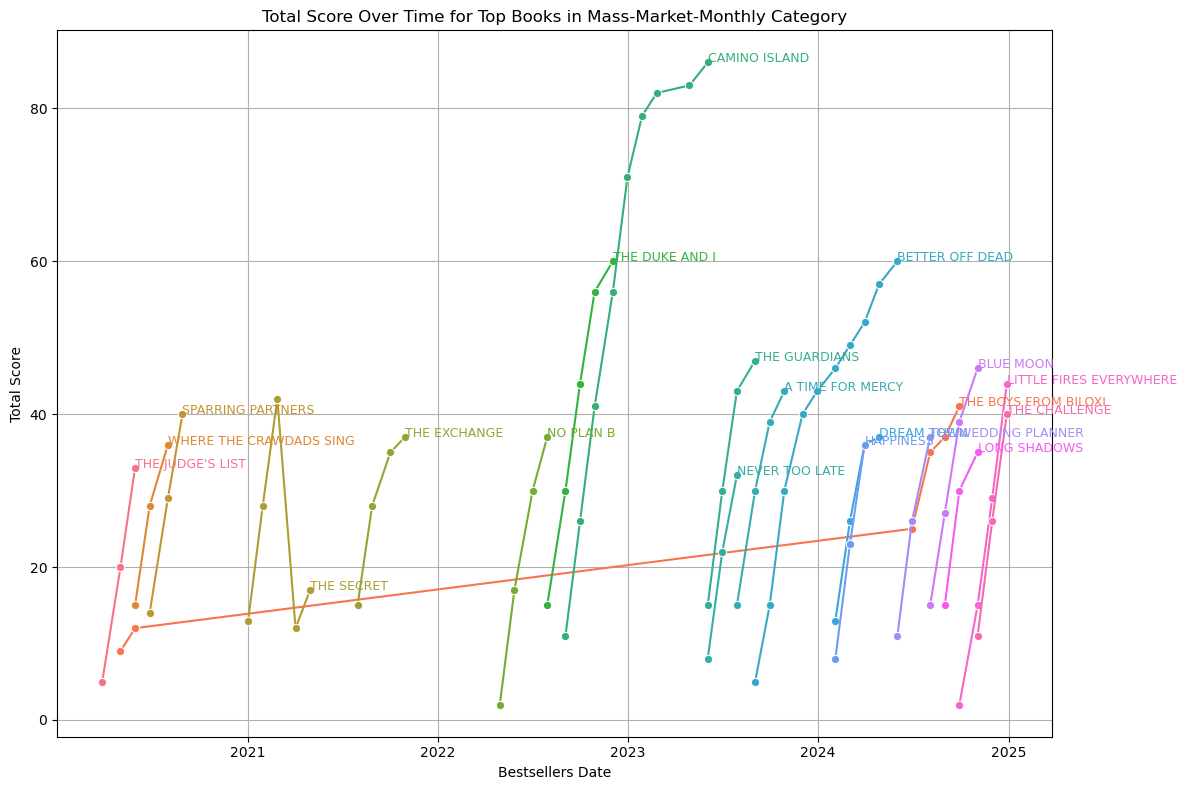

In [11]:
# Get the top 20 books
top_books_mass_market = books_df_filtered_mass_market.sort_values(by='total_score', ascending=False).drop_duplicates(subset=['title']).head(20)

# Plot it
plt.figure(figsize=(12, 8))
plot_data = books_df_filtered_mass_market[books_df_filtered_mass_market['title'].isin(top_books_mass_market['title'])]
plot = sns.lineplot(
    data=plot_data,
    x='bestsellers_date',
    y='total_score',
    hue='title',
    marker='o',
    legend=False
)

# Add book titles as text labels
for line, title in zip(plot.get_lines(), top_books_mass_market['title']):
    line_data = line.get_xydata()
    if line_data.size > 0:
        x, y = line_data[-1]  # last point
        color = line.get_color()  # color
        plt.text(x, y, title, horizontalalignment='left', fontsize=9, color=color)

plt.title("Total Score for Top Books - Mass Market")
plt.xlabel("Bestsellers Date")
plt.ylabel("Total Score")
plt.grid(True)
plt.tight_layout()

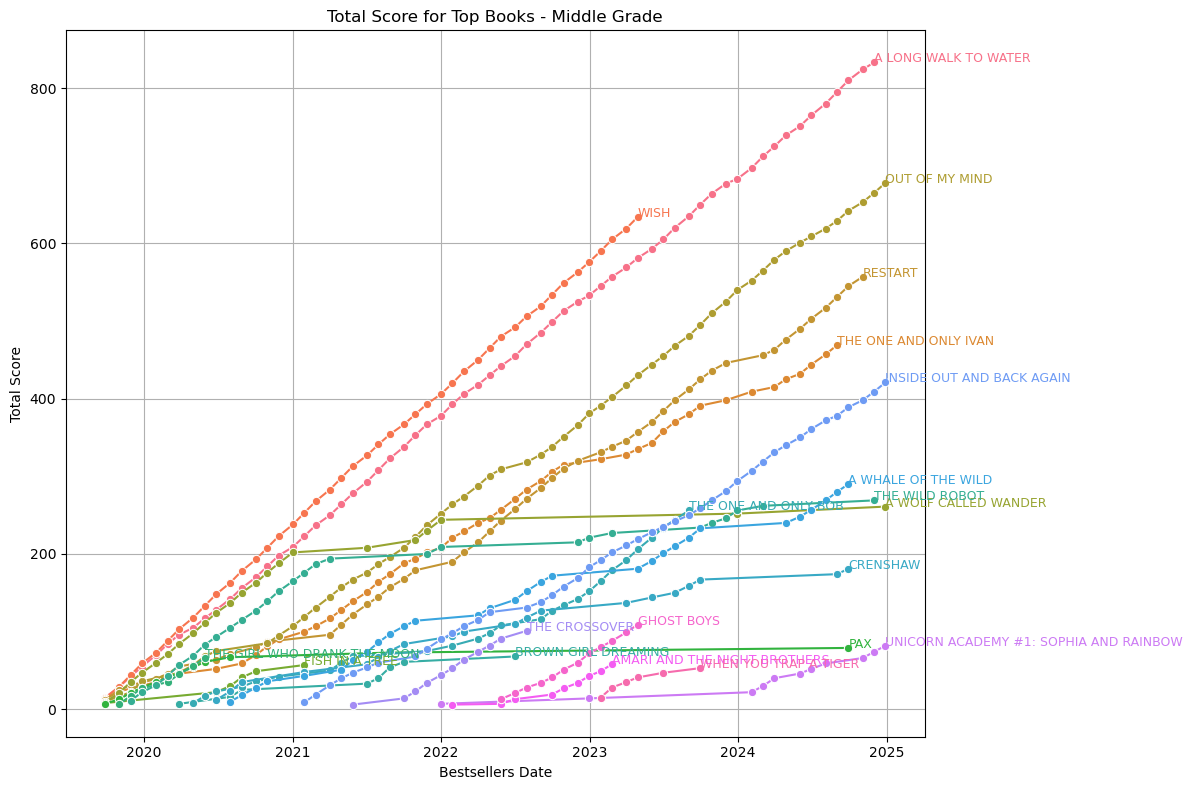

In [12]:
# Get the top 20 books
top_books_middle_grade = books_df_filtered_middle_grade.sort_values(by='total_score', ascending=False).drop_duplicates(subset=['title']).head(20)

# Plot it
plt.figure(figsize=(12, 8))
plot_data = books_df_filtered_middle_grade[books_df_filtered_middle_grade['title'].isin(top_books_middle_grade['title'])]
plot = sns.lineplot(
    data=plot_data,
    x='bestsellers_date',
    y='total_score',
    hue='title',
    marker='o',
    legend=False
)

# Add book titles as text labels
for line, title in zip(plot.get_lines(), top_books_middle_grade['title']):
    line_data = line.get_xydata()
    if line_data.size > 0:
        x, y = line_data[-1]  # last point
        color = line.get_color()  # color
        plt.text(x, y, title, horizontalalignment='left', fontsize=9, color=color)

plt.title("Total Score for Top Books - Middle Grade")
plt.xlabel("Bestsellers Date")
plt.ylabel("Total Score")
plt.grid(True)
plt.tight_layout()

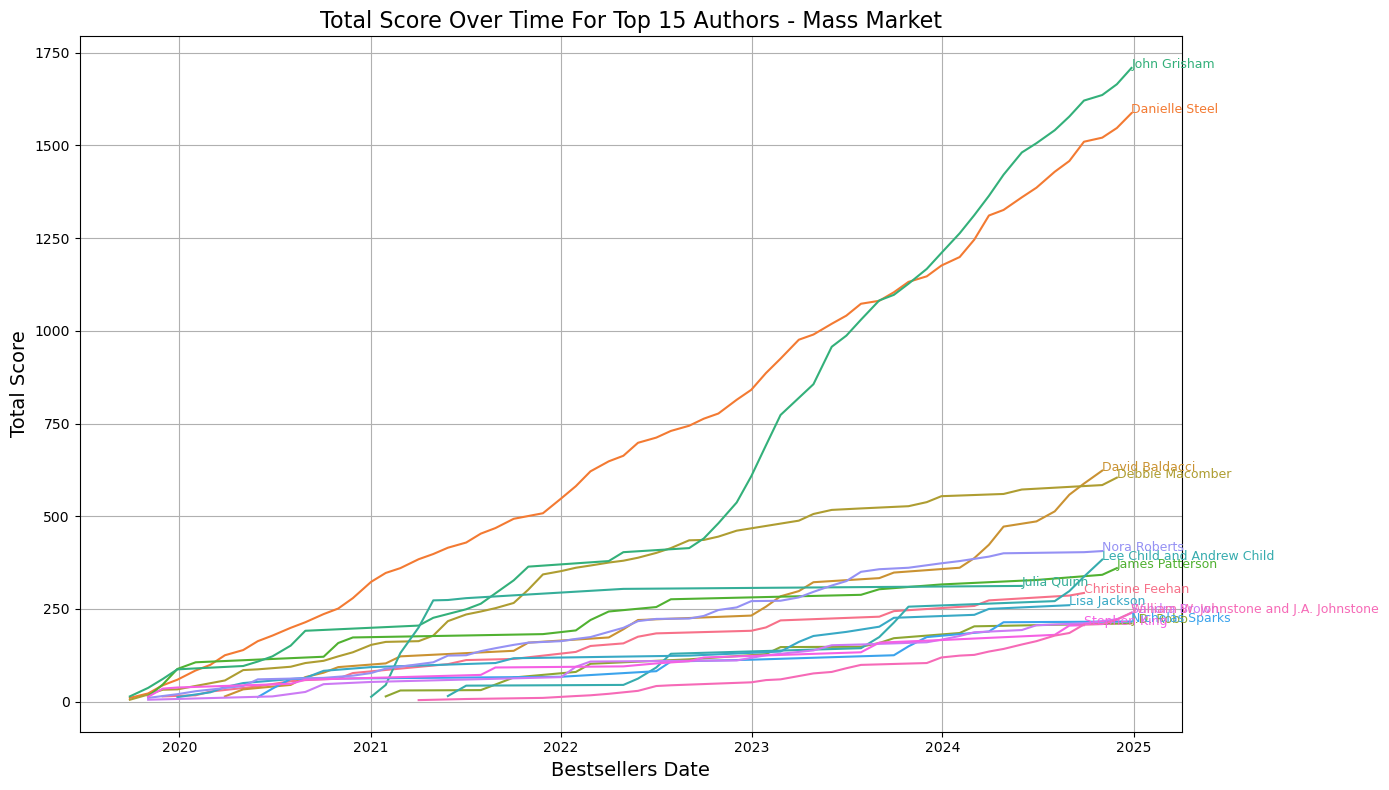

In [13]:
# Aggregating cumulative total score by author and bestsellers_date
aggregated_data_author_mass_market = books_df_filtered_mass_market.groupby(['author', 'bestsellers_date']).agg({'total_score': 'sum'}).groupby('author').cumsum().reset_index()

# Limit the number of authors by selecting the top ones based on total score
top_authors_mass_market = aggregated_data_author_mass_market.groupby('author')['total_score'].sum().nlargest(15).index
filtered_data_authors_mass_market = aggregated_data_author_mass_market[aggregated_data_author_mass_market['author'].isin(top_authors_mass_market)]

plt.figure(figsize=(14, 8))
plot = sns.lineplot(data=filtered_data_authors_mass_market, x='bestsellers_date', y='total_score', hue='author', legend=False)

# Add author names directly in the graph
top_author_names_mass_market = filtered_data_authors_mass_market['author'].unique()
for line, publisher in zip(plot.get_lines(), top_author_names_mass_market):
    line_data = line.get_xydata()
    x, y = line_data[-1]  # last point
    color = line.get_color()  # color
    plt.text(x, y, publisher, horizontalalignment='left', fontsize=9, color=color)

# Configure plot
plt.title("Total Score Over Time For Top 15 Authors - Mass Market", fontsize=16)
plt.xlabel("Bestsellers Date", fontsize=14)
plt.ylabel("Total Score", fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()

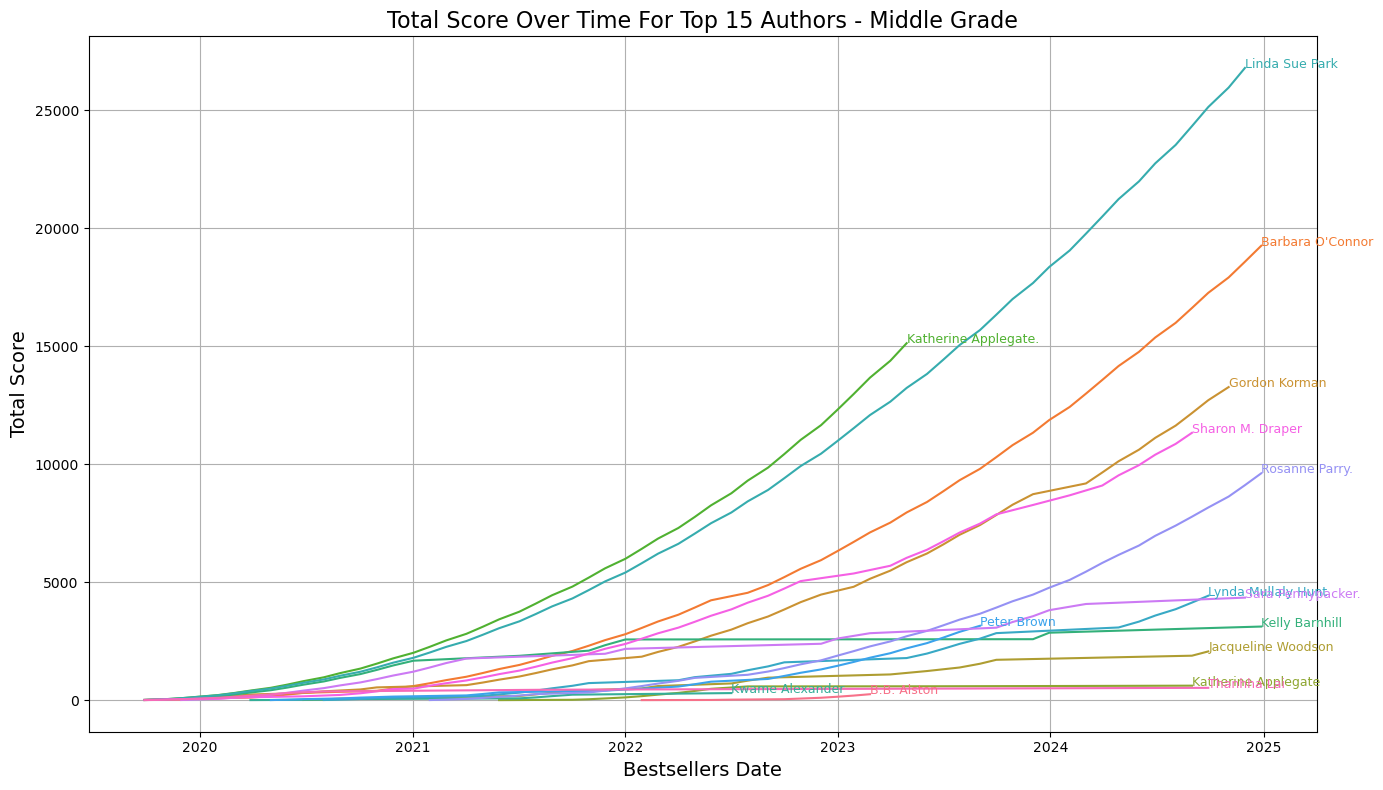

In [14]:
# Aggregating cumulative total score by author and bestsellers_date
aggregated_data_author_middle_grade = books_df_filtered_middle_grade.groupby(['author', 'bestsellers_date']).agg({'total_score': 'sum'}).groupby('author').cumsum().reset_index()

# Limit the number of authors by selecting the top ones based on total score
top_authors_middle_grade = aggregated_data_author_middle_grade.groupby('author')['total_score'].sum().nlargest(15).index
filtered_data_authors_middle_grade = aggregated_data_author_middle_grade[aggregated_data_author_middle_grade['author'].isin(top_authors_middle_grade)]

plt.figure(figsize=(14, 8))
plot = sns.lineplot(data=filtered_data_authors_middle_grade, x='bestsellers_date', y='total_score', hue='author', legend=False)

# Add author names directly in the graph
top_author_names_middle_grade = filtered_data_authors_middle_grade['author'].unique()
for line, publisher in zip(plot.get_lines(), top_author_names_middle_grade):
    line_data = line.get_xydata()
    x, y = line_data[-1]  # last point
    color = line.get_color()  # color
    plt.text(x, y, publisher, horizontalalignment='left', fontsize=9, color=color)

# Configure plot
plt.title("Total Score Over Time For Top 15 Authors - Middle Grade", fontsize=16)
plt.xlabel("Bestsellers Date", fontsize=14)
plt.ylabel("Total Score", fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()

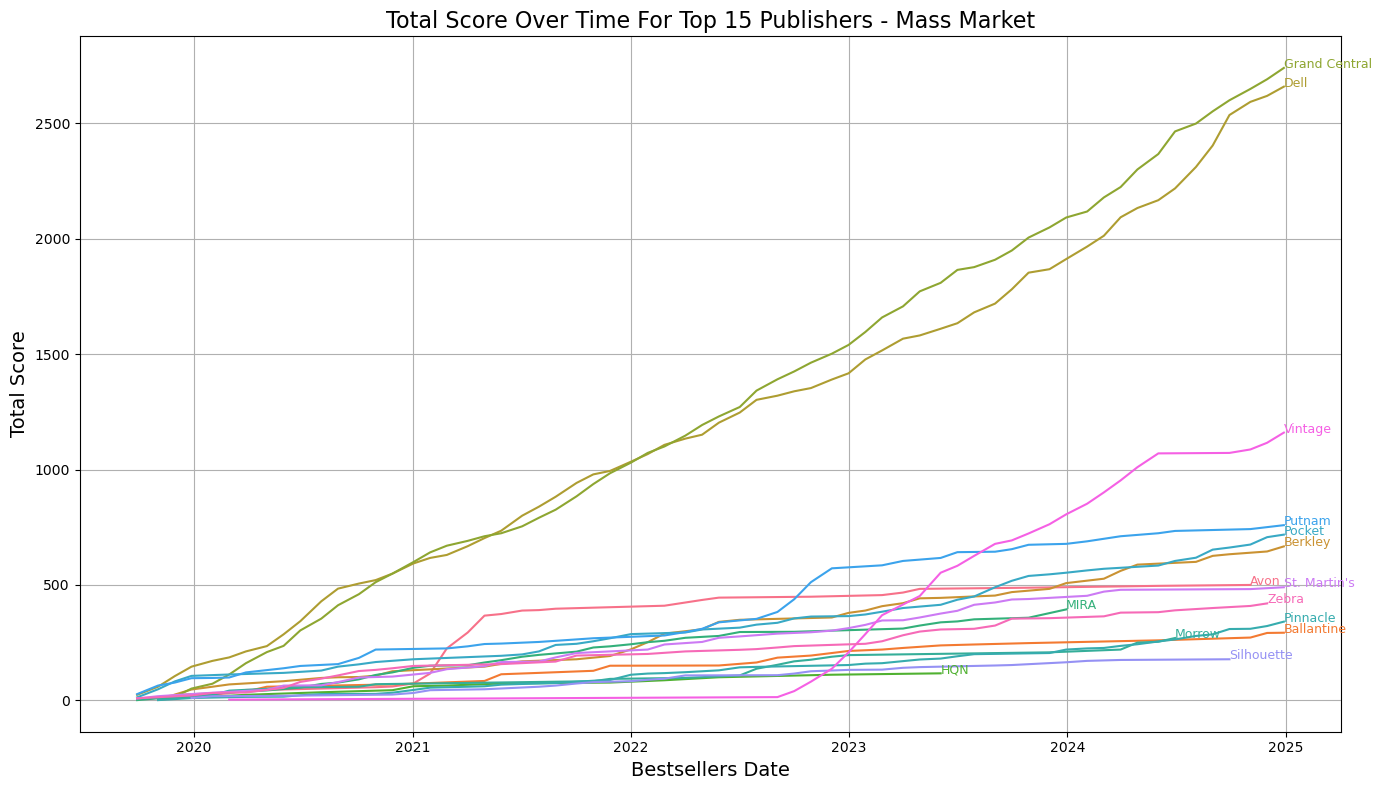

In [18]:
# Aggregating cumulative total score by publisher and bestsellers_date
aggregated_data_publisher_mass_market = books_df_filtered_mass_market.groupby(['publisher', 'bestsellers_date']).agg({'total_score': 'sum'}).groupby('publisher').cumsum().reset_index()

# Limit the number of publishers by selecting the top ones based on total score
top_publishers_mass_market = aggregated_data_publisher_mass_market.groupby('publisher')['total_score'].sum().nlargest(15).index
filtered_data_publishers_mass_market = aggregated_data_publisher_mass_market[aggregated_data_publisher_mass_market['publisher'].isin(top_publishers_mass_market)]

plt.figure(figsize=(14, 8))
plot = sns.lineplot(data=filtered_data_publishers_mass_market, x='bestsellers_date', y='total_score', hue='publisher', legend=False)

# Add publisher names directly in the graph
top_publisher_names_mass_market = filtered_data_publishers_mass_market['publisher'].unique()
for line, publisher in zip(plot.get_lines(), top_publisher_names_mass_market):
    line_data = line.get_xydata()
    x, y = line_data[-1]  # last point
    color = line.get_color()  # color
    plt.text(x, y, publisher, horizontalalignment='left', fontsize=9, color=color)

# Configure plot
plt.title("Total Score Over Time For Top 15 Publishers - Mass Market", fontsize=16)
plt.xlabel("Bestsellers Date", fontsize=14)
plt.ylabel("Total Score", fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()

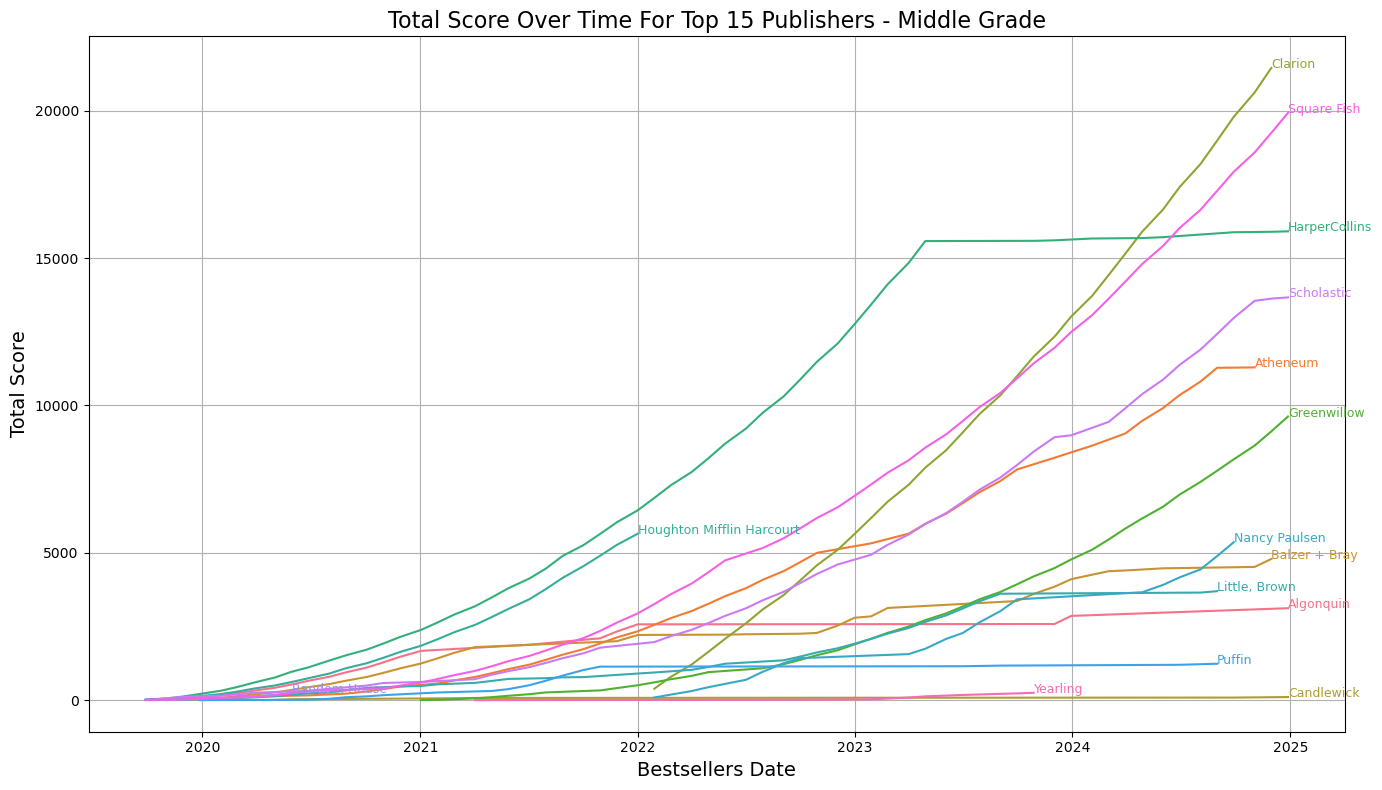

In [21]:
# Aggregating cumulative total score by publisher and bestsellers_date
aggregated_data_publisher_middle_grade = books_df_filtered_middle_grade.groupby(['publisher', 'bestsellers_date']).agg({'total_score': 'sum'}).groupby('publisher').cumsum().reset_index()

# Limit the number of publishers by selecting the top ones based on total score
top_publishers_middle_grade = aggregated_data_publisher_middle_grade.groupby('publisher')['total_score'].sum().nlargest(15).index
filtered_data_publishers_middle_grade = aggregated_data_publisher_middle_grade[aggregated_data_publisher_middle_grade['publisher'].isin(top_publishers_middle_grade)]

plt.figure(figsize=(14, 8))
plot = sns.lineplot(data=filtered_data_publishers_middle_grade, x='bestsellers_date', y='total_score', hue='publisher', legend=False)

# Add publisher names directly in the graph
top_publisher_names_middle_grade = filtered_data_publishers_middle_grade['publisher'].unique()
for line, publisher in zip(plot.get_lines(), top_publisher_names_middle_grade):
    line_data = line.get_xydata()
    x, y = line_data[-1]  # last point
    color = line.get_color()  # color
    plt.text(x, y, publisher, horizontalalignment='left', fontsize=9, color=color)

# Configure plot
plt.title("Total Score Over Time For Top 15 Publishers - Middle Grade", fontsize=16)
plt.xlabel("Bestsellers Date", fontsize=14)
plt.ylabel("Total Score", fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()